# Hypergraph information

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sb
from pathlib import Path
from scipy import linalg

from numpy.linalg import matrix_power, multi_dot
sb.set_theme(style="ticks", context="paper")

import string
from tqdm import tqdm
from math import factorial

In [2]:
#import simplicial_utils as su
import xgi
#import pygraphviz as pgv

In [3]:
# set folders
fig_dir = "figures/"

Path(fig_dir).mkdir(parents=True, exist_ok=True)

## Information functions

In [64]:
def construct_hg_multilayer(G):
    """
    returns:
    1) a list of Laplacians, ordered by their order!
    2) the total Laplacian matrix
    """
    max_d = xgi.max_edge_order(G)
    hg_m = []
    for d in range(1, max_d+1):
        #K, Adj, L = su.compute_laplacians(G, d+1)
        L = xgi.laplacian(G, d, rescale_per_node=False)
        K = xgi.degree_matrix(G, d)
        Adj = xgi.adjacency_matrix(G, d)
        hg_m.append(L)
    N = G.num_nodes
    hg_all = np.zeros((N,N))
    for l in range(len(hg_m)):
        hg_all = hg_all + hg_m[l]
    return hg_m, hg_all

def density(Lap,tau):  
    """
    Returns the density matrix for Laplacian
    """
    rho = linalg.expm(-2 * tau * Lap)
    rho = rho/np.trace(rho) + np.eye(len(rho))*10**-15
    return rho

def partition(Lap,tau):   
    """
    Returns the partition function
    """
    return np.trace(linalg.expm(-2 * tau * Lap))

def KL(rho_emp,rho_model):    
    """
    Returns the KL divergence between empirical observation and model
    """
    print(check_eigenspectrum(rho_emp))
    print(check_eigenspectrum(rho_model))
    return np.trace(  np.matmul(rho_emp, linalg.logm(rho_emp)) - np.matmul(rho_emp, linalg.logm(rho_model)))   

def optimization(G,tau):  
    """
    returns the gain and loss for modeling the whole hypergraph (up to order d_max),
    using a part of it, up to order d < d_max.
    """
    hg_m, hg_all = construct_hg_multilayer(G)
    rho_all = density(hg_all,tau)
    #print(len(rho_all))
    
    D = []
    lZ = []
    N = G.num_nodes
    L_l = np.zeros((N,N))
    for l in range(len(hg_m)):
        L_l = L_l + hg_m[l]
        rho_l = density(L_l,tau)
        Z_l   = partition(L_l,tau)

        D.append(KL(rho_all,rho_l)) 
        lZ.append(np.log(Z_l))

    lZ = np.array(lZ)   ### Penalization term for model complexity
    D = np.array(D)     ### Learning error
    
    return D, lZ

In [22]:
#def entropy(rho): # correct ?
#    return - np.trace(rho * np.log2(rho)) # number bits required to encore microstates logm

#def compute_entropy(H, tau):
#    hg_m, hg_all = construct_hg_multilayer(H)
#    rho_all = density(hg_all,tau)
#    return entropy(rho_all)

def entropy(L,tau):
    ### L is the Laplacian
    ### tau is the scale of signal propagation
    Ls = np.linalg.eigvals(L) # Calculate eigenvalues of L
    Z = np.sum(np.exp(-tau*Ls)) # Calculates the partition function
    p = np.exp(-tau*Ls)/Z # Calculates the probabilities
    #p=np.delete(p,np.where(p<10**-8))  # If probabilities are super small you may get NaNs. Activate this line to avoid NaN numerical errors.s
    S = np.sum( -p * np.log(p) )  # entropy
    return S

In [49]:
def KL_divergence_matrices(rho_emp, rho_model):
    """
    Returns the KL divergence between empirical observation and model
    """
    import numpy as np
    from scipy.linalg import logm, expm
    return np.real(np.trace(np.dot(rho_emp, logm(rho_emp) - logm(rho_model))))


In [55]:
def KL_divergence_matrices_fast(rho_emp, rho_model):
    """
    Returns the KL divergence between empirical observation and model
    """
    import numpy as np
    from scipy.linalg import eigh
    eigenvals_emp, eigenvecs_emp = eigh(rho_emp)
    eigenvals_model, eigenvecs_model = eigh(rho_model)
    log_eigenvals_emp = np.log(eigenvals_emp)
    log_eigenvals_model = np.log(eigenvals_model)
    return np.real(np.sum(eigenvals_emp * (log_eigenvals_emp - log_eigenvals_model)))


In [ ]:
N = 100 
p = 0.3
S = xgi.random_flag_complex(N, p, max_order=5)

In [26]:
xgi.num_edges_order(S, 5)

37

In [34]:
tau = 1                                    ### Tune the propagation scale in the system
hg_m, hg_all = construct_hg_multilayer(H0)  ### Makes a list of Laplacians of orders
#D, lZ = optimization(H0, tau)                ### Returns gain and loss 

In [35]:
rho_all = density(hg_all,tau)

In [36]:
L_l = hg_m[0]
rho_l = density(L_l,tau)
Z_l   = partition(L_l,tau)

In [53]:
%timeit KL(rho_all,rho_l)

1.01 s ± 70.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit KL_divergence_matrices(rho_all,rho_l)

1.02 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
KL_divergence_matrices(rho_all,rho_l)

0.26112901062959015

In [57]:
KL_divergence_matrices_fast(rho_all,rho_l)

0.2586263560730234

In [58]:
%timeit KL_divergence_matrices_fast(rho_all,rho_l)

11 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
def check_eigenspectrum(matrix, tol=1e-8):
    """
    Returns True if the eigenspectrum of a matrix is well-separated, False otherwise.
    """
    import numpy as np
    from scipy.linalg import eigh
    eigenvals, _ = eigh(matrix)
    diffs = np.diff(eigenvals)
    return np.all(diffs > tol)


In [61]:
%timeit check_eigenspectrum(rho_all)

5.18 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
%timeit check_eigenspectrum(rho_l)

5.74 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
def KL_SVD(rho_emp, rho_model, eps=1e-10):
    """
    Returns the KL divergence between empirical observation and model, calculated using SVD
    """
    import numpy as np
    from scipy.linalg import svd
    U, s, Vh = svd(rho_emp)
    D = np.diag(s)
    D += eps * np.eye(*D.shape)
    rho_emp_approx = U @ D @ Vh
    return np.trace(rho_emp @ np.log(rho_emp_approx) - rho_emp @ np.log(rho_model))


In [71]:
KL_SVD(rho_all,rho_l)

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_19598/2271823395.py:11: RuntimeWarning: divide by zero encountered in log
  return np.trace(rho_emp @ np.log(rho_emp_approx) - rho_emp @ np.log(rho_model))
/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_19598/2271823395.py:11: RuntimeWarning: invalid value encountered in matmul
  return np.trace(rho_emp @ np.log(rho_emp_approx) - rho_emp @ np.log(rho_model))


nan

In [93]:
KL_closed_form(rho_all,rho_l)

42.725783249998216

In [38]:
from scipy.stats import entropy

In [48]:
np.sum(entropy(qk=rho_all, pk=rho_l))

11.19628077386617

In [19]:
def compute_information(H, taus):
    
    n_t = len(taus)
    d_max = xgi.max_edge_order(H)
    orders = range(1, d_max + 1)
    
    Ds = np.zeros((n_t, d_max))
    lZs = np.zeros((n_t, d_max))
    
    for i, tau in enumerate(tqdm(taus)):
        Ds[i,:], lZs[i,:] = optimization(H, tau)
        
    return Ds, lZs, orders

In [20]:
def plot_information(H, taus, axs=None, label=None):

    if axs is None: 
        fig, axs = plt.subplots(
            1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
        )

    d_max = xgi.max_edge_order(H)
    orders = range(1, d_max + 1)

    for i, tau in enumerate(taus):

        D, lZ = optimization(H, tau)

        axs[i].plot(orders, lZ - D, "o-", label=label)

        axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
        axs[i].set_xlabel("Max order")
        axs[i].set_xticks(orders)

    axs[0].set_ylabel("Quality function")

    sb.despine()
    
    return plt.gcf(), axs

## Quality function at three different propagation scales

### random flag complex + config model

In [220]:
N = 100
#p = 0.3
#S = xgi.random_flag_complex(N, p, max_order=5)

G = nx.barabasi_albert_graph(n=N, m=10)
#G = nx.watts_strogatz_graph(n=50, k=9, p=0.7)

largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)
print(G)

S = xgi.flag_complex(G, ps=[0.1, 0.01, 0.001, 0.001], max_order=4)
print(xgi.max_edge_order(S))

Graph with 100 nodes and 900 edges
4


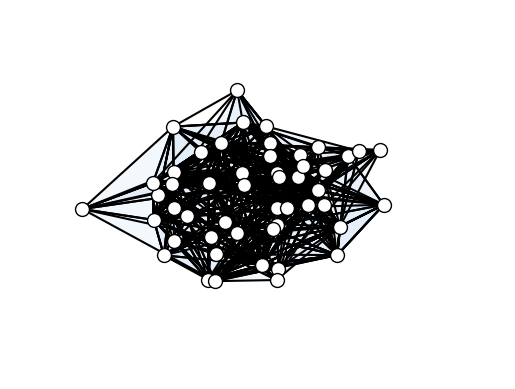

In [168]:
xgi.draw(S)

In [221]:
d_shuffle = 3

k2 = S.nodes.degree(order=d_shuffle).asdict()
edges_small = S.edges.filterby("order", d_shuffle, mode="lt").members()
edges_big = S.edges.filterby("order", d_shuffle, mode="gt").members()

In [222]:
H = xgi.uniform_hypergraph_configuration_model(k2, m=d_shuffle+1)
H.add_edges_from(edges_small)
H.add_edges_from(edges_big)

H.cleanup()

In [223]:
taus = [0.001, 0.01, 0.05]

Ds_S, lZs_S, orders = compute_information(S, taus)
Ds_H, lZs_H, _ = compute_information(H, taus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.26s/it]


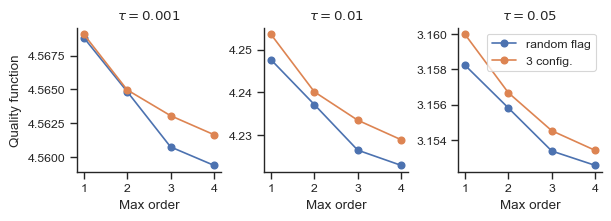

In [224]:
fig, axs = plt.subplots(
    1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
)

for i, tau in enumerate(taus):

    axs[i].plot(orders, lZs_S[i] - Ds_S[i], "o-", label="random flag")
    axs[i].plot(orders, lZs_H[i] - Ds_H[i], "o-", label=f"{d_shuffle} config.")

    axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
    axs[i].set_xlabel("Max order")
    axs[i].set_xticks(orders)

axs[0].set_ylabel("Quality function")
axs[-1].legend()
sb.despine()

### random flag complex + shuffle edges

In [8]:
import random 
def shuffle_hyperedges(order, p, S) :
    """Shuffle existing hyperdeges of order d with probablity p"""

    nodes = S.nodes
    #d_hyperedges = S.edges.filterby("order", 2).members(dtype=dict)
    #other_hyperedges = S.edges.filterby("order", order, mode="neq").members(dtype=dict)
    
    H = xgi.Hypergraph()
    H.add_nodes_from(nodes)
    H.add_edges_from(S._edge)

    d_hyperedges = H.edges.filterby("order", order).members(dtype=dict)
    
    for id_, members in d_hyperedges.items():
        if random.random() <= p:
            #print(id_, members)
            H.remove_edge(id_)
            new_hyperedge = tuple(random.sample(nodes, order+1))
            while new_hyperedge in H._edge.values():
                new_hyperedge = tuple(random.sample(nodes, order+1))
            H.add_edge(new_hyperedge)

    return H

In [64]:
N = 100 
p = 0.3
S = xgi.random_flag_complex(N, p, max_order=5)

In [86]:
d_shuffle = 4
p_shuffle = 0.9
H = shuffle_hyperedges(order=d_shuffle, p=p_shuffle, S=S)
H2 = shuffle_hyperedges(order=d_shuffle-1, p=p_shuffle, S=S)

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_83615/78737839.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  new_hyperedge = tuple(random.sample(nodes, order+1))


In [87]:
taus = [0.001, 0.01, 0.05]

Ds_S, lZs_S, orders = compute_information(S, taus)
Ds_H, lZs_H, _ = compute_information(H, taus)
Ds_H2, lZs_H2, _ = compute_information(H2, taus)

100%|█████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.79s/it]


In [88]:
assert H.num_edges == S.num_edges

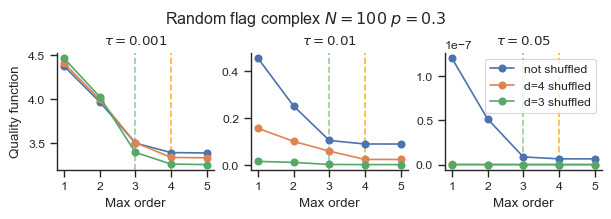

In [89]:
fig, axs = plt.subplots(
    1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
)

for i, tau in enumerate(taus):

    axs[i].plot(orders, lZs_S[i] - Ds_S[i], "o-", label="not shuffled")
    axs[i].plot(orders, lZs_H[i] - Ds_H[i], "o-", label=f"d={d_shuffle} shuffled")
    axs[i].plot(orders, lZs_H2[i] - Ds_H2[i], "o-", label=f"d={d_shuffle-1} shuffled")
    
    axs[i].axvline(d_shuffle, ls="--", c="orange", zorder=-2, alpha=0.8)
    axs[i].axvline(d_shuffle-1, ls="--", c="green", zorder=-2, alpha=0.4)

    axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
    axs[i].set_xlabel("Max order")
    axs[i].set_xticks(orders)

axs[0].set_ylabel("Quality function")
axs[-1].legend()

sb.despine()

fig.suptitle(f"Random flag complex $N={N}$ $p={p}$")

fig_name = f"random_flag_complex" 

plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

In [9]:
def entropy(L,tau):
    ### L is the Laplacian
    ### tau is the scale of signal propagation
    Ls = np.linalg.eigvals(L) # Calculate eigenvalues of L
    Z = np.sum(np.exp(-tau*Ls)) # Calculates the partition function
    p = np.exp(-tau*Ls)/Z # Calculates the probabilities
    #p=np.delete(p,np.where(p<10**-8))  # If probabilities are super small you may get NaNs. Activate this line to avoid NaN numerical errors.s
    S = np.sum( -p * np.log(p) )  # entropy
    return S

In [ ]:
Li = xgi.laplacian(H, d, rescale_per_node=False)

In [92]:
ents = {}

for i, tau in enumerate(taus):
    
    ents[tau] = {}
    
    for j, HG in enumerate([S, H, H2]):
        
        vals = [0, 4, 3] 
        
        d_max = xgi.max_edge_order(HG)
        L_multi = np.zeros((HG.num_nodes, HG.num_nodes))
        for d in range(1, d_max+1):
            #K, Adj, L = su.compute_laplacians(G, d+1)
            L = xgi.laplacian(HG, d, rescale_per_node=False)
            L_multi += L
        
        ent = entropy(L_multi, tau)
        
        ents[tau][vals[j]] = ent

In [93]:
ents_df = pd.DataFrame.from_dict(ents)
ents_df

ents_df_long = ents_df.stack().rename('entropy').to_frame().reset_index(names=["shuffle", "tau"])
ents_df_long

,shuffle,tau,entropy
0,0,0.001,4.551904e+00
1,0,0.010,2.488006e+00
2,0,0.050,1.627215e-03
3,4,0.001,4.565171e+00
4,4,0.010,2.044126e+00
5,4,0.050,6.710471e-05
6,3,0.001,4.584148e+00
7,3,0.010,1.190243e+00
8,3,0.050,4.616058e-08


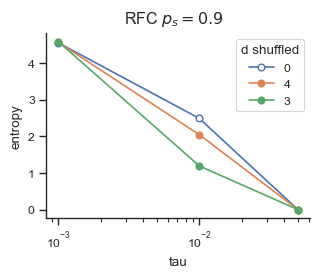

In [94]:
fig, ax  = plt.subplots(figsize=(3.4, 2.4))

for i, series in enumerate(ents_df.values):
    mfc = "w" if i==0 else None 
    ax.plot(ents_df.columns, series, "o-", label=ents_df.index[i], mfc=mfc)
    
ax.set_ylabel("entropy")
ax.set_xlabel("tau")
ax.legend(title="d shuffled")
ax.set_xscale("log", base=10)

sb.despine()

fig.suptitle(f"RFC $p_s={p_shuffle}$")

fig_name = f"random_flag_complex_entropy" 
plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

### hypergraph datasets

In [10]:
# set folders
out_dir = f"{fig_dir}datasets/"
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [6]:
# max_order argument not available online yet
#H_enron = xgi.load_xgi_data("email-enron", max_order=None)
#H_contact = xgi.load_xgi_data("contact-high-school", max_order=None)
#H_congress = xgi.load_xgi_data("congress-bills", max_order=None)
#H_email = xgi.load_xgi_data("email-eu", max_order=None)
#H_hospital = xgi.load_xgi_data("hospital-lyon", max_order=None)
#H_ubuntu = xgi.load_xgi_data("tags-ask-ubuntu", max_order=None)

data_names = [
    "email-enron",
    "email-eu",
    "hospital-lyon",
    "contact-high-school",
    "contact-primary-school",
    #"tags-ask-ubuntu",
    #"congress-bills",
    #"disgenenet",
    "diseasome",
    #"ndc-substances",
    #"coauth-mag-geology",
    #"coauth-mag-history",
]

HGs = {}
for name in tqdm(data_names): 
    HGs[name] = xgi.load_xgi_data(name, max_order=None, cache=True)


100%|█████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.93s/it]


In [25]:
i = 0
name = data_names[i]
print(name)
H0 = HGs[name]

#papers = pickle.load(open("PACS.pickle", "rb" ))
#papers_df = pd.DataFrame.from_dict(papers, orient="index")
#pacs = 8
#H0 = xgi.Hypergraph(papers_df[papers_df["PACS"]==str(pacs)]["authors"].tolist())

print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=True)
print(H0)



#H = shuffle_hyperedges(order=d_shuffle, p=p_shuffle, S=H0)
#H1 = shuffle_hyperedges(order=d_shuffle + 1, p=p_shuffle, S=H0)
#H2 = shuffle_hyperedges(order=d_shuffle + 2, p=p_shuffle, S=H0)

email-enron
Hypergraph named email-Enron with 148 nodes and 10885 hyperedges
max order: 36
Hypergraph named email-Enron with 148 nodes and 1459 hyperedges


In [26]:
#d_shuffles = [10, 20, 30]
d_shuffles = [3, 5, 7]

p_shuffle = 0.9

Hs = []

for d_shuffle in d_shuffles:
    if d_shuffle <= xgi.max_edge_order(H0):
        print(d_shuffle)
        Hs.append(shuffle_hyperedges(order=d_shuffle, p=p_shuffle, S=H0))

3
5
7


/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_19598/78737839.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  new_hyperedge = tuple(random.sample(nodes, order+1))


In [27]:
%timeit xgi.incidence_matrix(H0, order=2)

3.75 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit xgi.laplacian(H0, order=4)

5.45 ms ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%prun optimization(H0, 0.1)

In [31]:
%load_ext line_profiler

In [32]:
%lprun -f optimization optimization(H0, 0.1)

In [13]:
taus = [0.01, 0.1, 1]

Ds_H0, lZs_H0, orders = compute_information(H0, taus)

Ds_H = []
lZs_H = []

for i, H in enumerate(Hs):
    Ds_Hi, lZs_Hi, _ = compute_information(H, taus)
    Ds_H.append(Ds_Hi)
    lZs_H.append(lZs_Hi)
        
#Ds_H, lZs_H, _ = compute_information(H, taus)
#Ds_H1, lZs_H1, _ = compute_information(H1, taus)
#Ds_H2, lZs_H2, _ = compute_information(H2, taus)

  0%|                                                         | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 4.3645204726208306e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 5.430426319077029e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 6.205585570166315e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 6.182649968469764e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 7.913723071329308e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 7.460663791660127e-13
logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm 

 33%|████████████████▎                                | 1/3 [00:38<01:16, 38.23s/it]

logm result may be inaccurate, approximate err = 8.599979691873321e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 3.870016382535047e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 4.460559688144104e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 5.857104091830637e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 6.281805152520595e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 5.2808879678152e-13
logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 6.080330132778968e-13
logm res

 67%|████████████████████████████████▋                | 2/3 [01:22<00:41, 41.53s/it]

logm result may be inaccurate, approximate err = 6.988650921344307e-13
logm result may be inaccurate, approximate err = 2.479726371020098e-13
logm result may be inaccurate, approximate err = 2.237973672233344e-13


  0%|                                                         | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 4.3645204726208306e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 5.455248662856637e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 6.988023542521865e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 7.904108670443977e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 7.43197766184919e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm result may be inaccurate, approximate err = 8.205266156673997e-13
logm result may be inaccurate, approximate err = 8.347047075719594e-13
logm r

 33%|████████████████▎                                | 1/3 [00:32<01:04, 32.41s/it]

logm result may be inaccurate, approximate err = 8.236267477641475e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm result may be inaccurate, approximate err = 3.8513238231415343e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm result may be inaccurate, approximate err = 3.8590891286540506e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm result may be inaccurate, approximate err = 4.90618708106203e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm result may be inaccurate, approximate err = 5.411659866742089e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm result may be inaccurate, approximate err = 5.472650749728564e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm result may be inaccurate, approximate err = 5.584922627945883e-13
logm result may be inaccurate, approximate err = 5.257116166070654e-13
logm 

 67%|████████████████████████████████▋                | 2/3 [01:12<00:37, 37.10s/it]

logm result may be inaccurate, approximate err = 5.257116166070654e-13


  0%|                                                         | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 4.3645204726208306e-13
logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 5.430426319077029e-13
logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 6.205585570166315e-13
logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 6.609051964897796e-13
logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 7.32944626248017e-13
logm result may be inaccurate, approximate err = 1.4196052619417903e-12
logm result may be inaccurate, approximate err = 8.057686790306306e-13
logm result may be inaccurate, approximate err = 1.4196052619417903e-1

 33%|████████████████▎                                | 1/3 [00:34<01:08, 34.23s/it]

logm result may be inaccurate, approximate err = 7.907959756654079e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 3.2535020018522473e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 3.870016382535047e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 4.460559688144104e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 5.857104091830637e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 5.541341454017611e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 5.741743871652108e-13
logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm 

 67%|████████████████████████████████▋                | 2/3 [01:13<00:36, 36.93s/it]

logm result may be inaccurate, approximate err = 5.200801717155389e-13
logm result may be inaccurate, approximate err = 2.479726371020098e-13


  0%|                                                         | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 4.3645204726208306e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 5.430426319077029e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 6.205585570166315e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 6.182649968469764e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 7.913723071329308e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm result may be inaccurate, approximate err = 6.65922967998929e-13
logm result may be inaccurate, approximate err = 9.267296332037392e-13
logm r

 33%|████████████████▎                                | 1/3 [00:34<01:08, 34.46s/it]

logm result may be inaccurate, approximate err = 9.629982097461247e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 3.453939838677683e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 3.870016382535047e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 4.460559688144104e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 5.857104091830637e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 6.281805152520595e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 5.2808879678152e-13
logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm res

 67%|████████████████████████████████▋                | 2/3 [01:15<00:38, 38.25s/it]

logm result may be inaccurate, approximate err = 7.831215781814981e-13
logm result may be inaccurate, approximate err = 2.479726371020098e-13
logm result may be inaccurate, approximate err = 2.237973672233344e-13


100%|█████████████████████████████████████████████████| 3/3 [01:59<00:00, 39.76s/it]


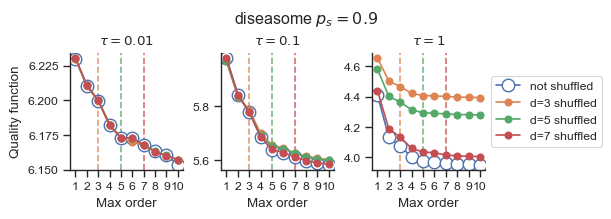

In [14]:
fig, axs = plt.subplots(
    1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
)

for i, tau in enumerate(taus):

    axs[i].plot(orders, lZs_H0[i] - Ds_H0[i], "o-", label="not shuffled", ms=9, mfc="w")
    
    for j, H in enumerate(Hs):
        
        axs[i].plot(orders, lZs_H[j][i] - Ds_H[j][i], "o-", label=f"d={d_shuffles[j]} shuffled")
    
    #axs[i].plot(orders, lZs_H1[i] - Ds_H1[i], "o-", label=f"d={d_shuffle+1} shuffled")
    #axs[i].plot(orders, lZs_H2[i] - Ds_H2[i], "o-", label=f"d={d_shuffle+2} shuffled")
    
        axs[i].axvline(d_shuffles[j], ls="--", c=f"C{j+1}", zorder=-2, alpha=0.8)
    #axs[i].axvline(d_shuffle+1, ls="--", c="C2", zorder=-2, alpha=0.4)
    #axs[i].axvline(d_shuffle+2, ls="--", c="C3", zorder=-2, alpha=0.4)

    axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
    axs[i].set_xlabel("Max order")
    axs[i].set_xticks(orders)

axs[0].set_ylabel("Quality function")
axs[-1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

sb.despine()

fig.suptitle(f"{name} $p_s={p_shuffle}$")

fig_name = f"info_{name}_p_s_{p_shuffle}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [15]:
H0

In [16]:
Hs

In [17]:
ents = {}

for i, tau in enumerate(taus):
    
    ents[tau] = {}
    
    for j, HG in enumerate([H0] + Hs):        
        d_max = xgi.max_edge_order(HG)
        L_multi = np.zeros((HG.num_nodes, HG.num_nodes))
        for d in range(1, d_max+1):
            #K, Adj, L = su.compute_laplacians(G, d+1)
            L = xgi.laplacian(HG, d, rescale_per_node=False)
            L_multi += L
        
        ent = entropy(L_multi, tau)
        
        dd = 0 if j==0 else d_shuffles[j-1]
        ents[tau][dd] = ent
        
ents_df = pd.DataFrame.from_dict(ents)
        
ents_df_long = ents_df.stack().rename('entropy').to_frame().reset_index(names=["shuffle", "tau"])
ents_df

,0.01,0.10,1.00
0,6.244639+0.000000j,6.175864+0.000000j,5.349064+0.000000j
3,6.244677+0.000000j,6.169381+0.000000j,5.324117+0.000000j
5,6.244650+0.000000j,6.170735+0.000000j,5.340544+0.000000j
7,6.244708+0.000000j,6.174265+0.000000j,5.350023+0.000000j


/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


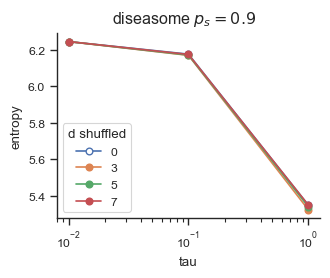

In [18]:
fig, ax  = plt.subplots(figsize=(3.4, 2.4))

for i, series in enumerate(ents_df.values):
    mfc = "w" if i==0 else None 
    ax.plot(ents_df.columns, series, "o-", label=ents_df.index[i], mfc=mfc)
    
ax.set_ylabel("entropy")
ax.set_xlabel("tau")
ax.legend(title="d shuffled")
ax.set_xscale("log", base=10)

sb.despine()

fig.suptitle(f"{name} $p_s={p_shuffle}$")

fig_name = f"info_{name}_p_s_{p_shuffle}_entropy" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

### Datasets Fede overlapping

In [19]:
xgi.load_xgi_data()

Available datasets are the following:
coauth-mag-geology
coauth-mag-history
congress-bills
contact-high-school
contact-primary-school
diseasome
disgenenet
email-enron
email-eu
hospital-lyon
ndc-substances
tags-ask-ubuntu
tags-math-sx
tags-stack-exchange


TypeError: 'NoneType' object is not subscriptable

### random simplicial complex

In [51]:
N = 50 # number of nodes
ps=[0.05, 0.001, 0.0001, 0.00001] # wiring probabilities at each order

#H = xgi.random_hypergraph(50, ps=ps)
S = xgi.random_simplicial_complex(N=N, ps=ps)

50
50
50


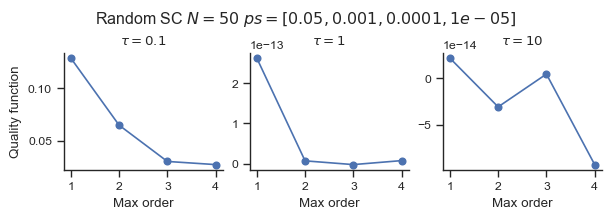

In [52]:
taus = [0.1, 1, 10]

fig = plot_information(S, taus)
plt.suptitle(f"Random SC $N={N}$ $ps={ps}$")

fig_name = f"random_SC_N_{N}_ps_{ps}"
plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

### random hypergraph

In [58]:
N = 50  # number of nodes
ps = [0.05, 0.001, 0.0001, 0.00001]  # wiring probabilities at each order

H = xgi.random_hypergraph(N, ps=ps)

50
50
50


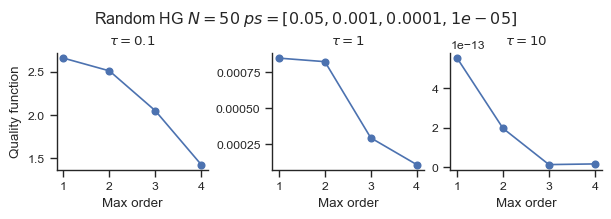

In [59]:
taus = [0.1, 1, 10]

fig = plot_information(H, taus)
plt.suptitle(f"Random HG $N={N}$ $ps={ps}$")

fig_name = f"random_HG_N_{N}_ps_{ps}"
plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

### multiple realisations

In [ ]:
n_rep = 5

N = 50  # number of nodes
ps = [0.05, 0.001, 0.0001, 0.00001]  # wiring probabilities at each order

SCs = []

fig, axs = plt.subplots(
    1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
)

for j in range(n_rep):
    
    S = xgi.random_simplicial_complex(N=N, ps=ps)

    d_max = xgi.max_edge_order()
    orders = range(1, d_max + 1)

    for i, tau in enumerate(taus):

        D, lZ = optimization(H, tau)

In [3]:
import pickle, math

papers = pickle.load(open("PACS.pickle", "rb" ))

In [10]:
import pandas as pd 
papers = pickle.load(open("PACS.pickle", "rb" ))
papers_df = pd.DataFrame.from_dict(papers, orient="index")
papers_df

,authors,PACS
000234337900076,"[0, 5480, 11137, 11274, 28428, 26239, 28771, 4...",0
000234334900120,"[1, 34922, 1, 34922, 1, 34922]",0
000228752500002,"[2, 11584]",0
000233458500006,"[3, 5253, 1423, 3, 5253, 1423]",0
000230886900002,"[4, 2900, 11874, 4, 2900, 11874]",0
...,...,...
000320167600001,[23735],9
000315738400004,[282150],9
000313028500007,[59068],9
000323318000006,[8346],9


In [2]:
pickle_PACS()

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_83615/4065538728.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tb = pd.read_csv("data/PACS.csv")


1000 (3726262, 3)
2000 (3726262, 3)
3000 (3726262, 3)
4000 (3726262, 3)
5000 (3726262, 3)
6000 (3726262, 3)
7000 (3726262, 3)
8000 (3726262, 3)
9000 (3726262, 3)
10000 (3726262, 3)
11000 (3726262, 3)
12000 (3726262, 3)
13000 (3726262, 3)
14000 (3726262, 3)
15000 (3726262, 3)
16000 (3726262, 3)
17000 (3726262, 3)
18000 (3726262, 3)
19000 (3726262, 3)
20000 (3726262, 3)
21000 (3726262, 3)
22000 (3726262, 3)
23000 (3726262, 3)
24000 (3726262, 3)
25000 (3726262, 3)
26000 (3726262, 3)
27000 (3726262, 3)
28000 (3726262, 3)
29000 (3726262, 3)
30000 (3726262, 3)
31000 (3726262, 3)
32000 (3726262, 3)
33000 (3726262, 3)
34000 (3726262, 3)
35000 (3726262, 3)
36000 (3726262, 3)
37000 (3726262, 3)
38000 (3726262, 3)
39000 (3726262, 3)
40000 (3726262, 3)
41000 (3726262, 3)
42000 (3726262, 3)
43000 (3726262, 3)
44000 (3726262, 3)
45000 (3726262, 3)
46000 (3726262, 3)
47000 (3726262, 3)
48000 (3726262, 3)
49000 (3726262, 3)
50000 (3726262, 3)
51000 (3726262, 3)
52000 (3726262, 3)
53000 (3726262, 3)
54

424000 (3726262, 3)
425000 (3726262, 3)
426000 (3726262, 3)
427000 (3726262, 3)
428000 (3726262, 3)
429000 (3726262, 3)
430000 (3726262, 3)
431000 (3726262, 3)
432000 (3726262, 3)
433000 (3726262, 3)
434000 (3726262, 3)
435000 (3726262, 3)
436000 (3726262, 3)
437000 (3726262, 3)
438000 (3726262, 3)
439000 (3726262, 3)
440000 (3726262, 3)
441000 (3726262, 3)
442000 (3726262, 3)
443000 (3726262, 3)
444000 (3726262, 3)
445000 (3726262, 3)
446000 (3726262, 3)
447000 (3726262, 3)
448000 (3726262, 3)
449000 (3726262, 3)
450000 (3726262, 3)
451000 (3726262, 3)
452000 (3726262, 3)
453000 (3726262, 3)
454000 (3726262, 3)
455000 (3726262, 3)
456000 (3726262, 3)
457000 (3726262, 3)
458000 (3726262, 3)
459000 (3726262, 3)
460000 (3726262, 3)
461000 (3726262, 3)
462000 (3726262, 3)
463000 (3726262, 3)
464000 (3726262, 3)
465000 (3726262, 3)
466000 (3726262, 3)
467000 (3726262, 3)
468000 (3726262, 3)
469000 (3726262, 3)
470000 (3726262, 3)
471000 (3726262, 3)
472000 (3726262, 3)
473000 (3726262, 3)


836000 (3726262, 3)
837000 (3726262, 3)
838000 (3726262, 3)
839000 (3726262, 3)
840000 (3726262, 3)
841000 (3726262, 3)
842000 (3726262, 3)
843000 (3726262, 3)
844000 (3726262, 3)
845000 (3726262, 3)
846000 (3726262, 3)
847000 (3726262, 3)
848000 (3726262, 3)
849000 (3726262, 3)
850000 (3726262, 3)
851000 (3726262, 3)
852000 (3726262, 3)
853000 (3726262, 3)
854000 (3726262, 3)
855000 (3726262, 3)
856000 (3726262, 3)
857000 (3726262, 3)
858000 (3726262, 3)
859000 (3726262, 3)
860000 (3726262, 3)
861000 (3726262, 3)
862000 (3726262, 3)
863000 (3726262, 3)
864000 (3726262, 3)
865000 (3726262, 3)
866000 (3726262, 3)
867000 (3726262, 3)
868000 (3726262, 3)
869000 (3726262, 3)
870000 (3726262, 3)
871000 (3726262, 3)
872000 (3726262, 3)
873000 (3726262, 3)
874000 (3726262, 3)
875000 (3726262, 3)
876000 (3726262, 3)
877000 (3726262, 3)
878000 (3726262, 3)
879000 (3726262, 3)
880000 (3726262, 3)
881000 (3726262, 3)
882000 (3726262, 3)
883000 (3726262, 3)
884000 (3726262, 3)
885000 (3726262, 3)


1244000 (3726262, 3)
1245000 (3726262, 3)
1246000 (3726262, 3)
1247000 (3726262, 3)
1248000 (3726262, 3)
1249000 (3726262, 3)
1250000 (3726262, 3)
1251000 (3726262, 3)
1252000 (3726262, 3)
1253000 (3726262, 3)
1254000 (3726262, 3)
1255000 (3726262, 3)
1256000 (3726262, 3)
1257000 (3726262, 3)
1258000 (3726262, 3)
1259000 (3726262, 3)
1260000 (3726262, 3)
1261000 (3726262, 3)
1262000 (3726262, 3)
1263000 (3726262, 3)
1264000 (3726262, 3)
1265000 (3726262, 3)
1266000 (3726262, 3)
1267000 (3726262, 3)
1268000 (3726262, 3)
1269000 (3726262, 3)
1270000 (3726262, 3)
1271000 (3726262, 3)
1272000 (3726262, 3)
1273000 (3726262, 3)
1274000 (3726262, 3)
1275000 (3726262, 3)
1276000 (3726262, 3)
1277000 (3726262, 3)
1278000 (3726262, 3)
1279000 (3726262, 3)
1280000 (3726262, 3)
1281000 (3726262, 3)
1282000 (3726262, 3)
1283000 (3726262, 3)
1284000 (3726262, 3)
1285000 (3726262, 3)
1286000 (3726262, 3)
1287000 (3726262, 3)
1288000 (3726262, 3)
1289000 (3726262, 3)
1290000 (3726262, 3)
1291000 (3726

1640000 (3726262, 3)
1641000 (3726262, 3)
1642000 (3726262, 3)
1643000 (3726262, 3)
1644000 (3726262, 3)
1645000 (3726262, 3)
1646000 (3726262, 3)
1647000 (3726262, 3)
1648000 (3726262, 3)
1649000 (3726262, 3)
1650000 (3726262, 3)
1651000 (3726262, 3)
1652000 (3726262, 3)
1653000 (3726262, 3)
1654000 (3726262, 3)
1655000 (3726262, 3)
1656000 (3726262, 3)
1657000 (3726262, 3)
1658000 (3726262, 3)
1659000 (3726262, 3)
1660000 (3726262, 3)
1661000 (3726262, 3)
1662000 (3726262, 3)
1663000 (3726262, 3)
1664000 (3726262, 3)
1665000 (3726262, 3)
1666000 (3726262, 3)
1667000 (3726262, 3)
1668000 (3726262, 3)
1669000 (3726262, 3)
1670000 (3726262, 3)
1671000 (3726262, 3)
1672000 (3726262, 3)
1673000 (3726262, 3)
1674000 (3726262, 3)
1675000 (3726262, 3)
1676000 (3726262, 3)
1677000 (3726262, 3)
1678000 (3726262, 3)
1679000 (3726262, 3)
1680000 (3726262, 3)
1681000 (3726262, 3)
1682000 (3726262, 3)
1683000 (3726262, 3)
1684000 (3726262, 3)
1685000 (3726262, 3)
1686000 (3726262, 3)
1687000 (3726

2032000 (3726262, 3)
2033000 (3726262, 3)
2034000 (3726262, 3)
2035000 (3726262, 3)
2036000 (3726262, 3)
2037000 (3726262, 3)
2038000 (3726262, 3)
2039000 (3726262, 3)
2040000 (3726262, 3)
2041000 (3726262, 3)
2042000 (3726262, 3)
2043000 (3726262, 3)
2044000 (3726262, 3)
2045000 (3726262, 3)
2046000 (3726262, 3)
2047000 (3726262, 3)
2048000 (3726262, 3)
2049000 (3726262, 3)
2050000 (3726262, 3)
2051000 (3726262, 3)
2052000 (3726262, 3)
2053000 (3726262, 3)
2054000 (3726262, 3)
2055000 (3726262, 3)
2056000 (3726262, 3)
2057000 (3726262, 3)
2058000 (3726262, 3)
2059000 (3726262, 3)
2060000 (3726262, 3)
2061000 (3726262, 3)
2062000 (3726262, 3)
2063000 (3726262, 3)
2064000 (3726262, 3)
2065000 (3726262, 3)
2066000 (3726262, 3)
2067000 (3726262, 3)
2068000 (3726262, 3)
2069000 (3726262, 3)
2070000 (3726262, 3)
2071000 (3726262, 3)
2072000 (3726262, 3)
2073000 (3726262, 3)
2074000 (3726262, 3)
2075000 (3726262, 3)
2076000 (3726262, 3)
2077000 (3726262, 3)
2078000 (3726262, 3)
2079000 (3726

2427000 (3726262, 3)
2428000 (3726262, 3)
2429000 (3726262, 3)
2430000 (3726262, 3)
2431000 (3726262, 3)
2432000 (3726262, 3)
2433000 (3726262, 3)
2434000 (3726262, 3)
2435000 (3726262, 3)
2436000 (3726262, 3)
2437000 (3726262, 3)
2438000 (3726262, 3)
2439000 (3726262, 3)
2440000 (3726262, 3)
2441000 (3726262, 3)
2442000 (3726262, 3)
2443000 (3726262, 3)
2444000 (3726262, 3)
2445000 (3726262, 3)
2446000 (3726262, 3)
2447000 (3726262, 3)
2448000 (3726262, 3)
2449000 (3726262, 3)
2450000 (3726262, 3)
2451000 (3726262, 3)
2452000 (3726262, 3)
2453000 (3726262, 3)
2454000 (3726262, 3)
2455000 (3726262, 3)
2456000 (3726262, 3)
2457000 (3726262, 3)
2458000 (3726262, 3)
2459000 (3726262, 3)
2460000 (3726262, 3)
2461000 (3726262, 3)
2462000 (3726262, 3)
2463000 (3726262, 3)
2464000 (3726262, 3)
2465000 (3726262, 3)
2466000 (3726262, 3)
2467000 (3726262, 3)
2468000 (3726262, 3)
2469000 (3726262, 3)
2470000 (3726262, 3)
2471000 (3726262, 3)
2472000 (3726262, 3)
2473000 (3726262, 3)
2474000 (3726

2823000 (3726262, 3)
2824000 (3726262, 3)
2825000 (3726262, 3)
2826000 (3726262, 3)
2827000 (3726262, 3)
2828000 (3726262, 3)
2829000 (3726262, 3)
2830000 (3726262, 3)
2831000 (3726262, 3)
2832000 (3726262, 3)
2833000 (3726262, 3)
2834000 (3726262, 3)
2835000 (3726262, 3)
2836000 (3726262, 3)
2837000 (3726262, 3)
2838000 (3726262, 3)
2839000 (3726262, 3)
2840000 (3726262, 3)
2841000 (3726262, 3)
2842000 (3726262, 3)
2843000 (3726262, 3)
2844000 (3726262, 3)
2845000 (3726262, 3)
2846000 (3726262, 3)
2847000 (3726262, 3)
2848000 (3726262, 3)
2849000 (3726262, 3)
2850000 (3726262, 3)
2851000 (3726262, 3)
2852000 (3726262, 3)
2853000 (3726262, 3)
2854000 (3726262, 3)
2855000 (3726262, 3)
2856000 (3726262, 3)
2857000 (3726262, 3)
2858000 (3726262, 3)
2859000 (3726262, 3)
2860000 (3726262, 3)
2861000 (3726262, 3)
2862000 (3726262, 3)
2863000 (3726262, 3)
2864000 (3726262, 3)
2865000 (3726262, 3)
2866000 (3726262, 3)
2867000 (3726262, 3)
2868000 (3726262, 3)
2869000 (3726262, 3)
2870000 (3726

3215000 (3726262, 3)
3216000 (3726262, 3)
3217000 (3726262, 3)
3218000 (3726262, 3)
3219000 (3726262, 3)
3220000 (3726262, 3)
3221000 (3726262, 3)
3222000 (3726262, 3)
3223000 (3726262, 3)
3224000 (3726262, 3)
3225000 (3726262, 3)
3226000 (3726262, 3)
3227000 (3726262, 3)
3228000 (3726262, 3)
3229000 (3726262, 3)
3230000 (3726262, 3)
3231000 (3726262, 3)
3232000 (3726262, 3)
3233000 (3726262, 3)
3234000 (3726262, 3)
3235000 (3726262, 3)
3236000 (3726262, 3)
3237000 (3726262, 3)
3238000 (3726262, 3)
3239000 (3726262, 3)
3240000 (3726262, 3)
3241000 (3726262, 3)
3242000 (3726262, 3)
3243000 (3726262, 3)
3244000 (3726262, 3)
3245000 (3726262, 3)
3246000 (3726262, 3)
3247000 (3726262, 3)
3248000 (3726262, 3)
3249000 (3726262, 3)
3250000 (3726262, 3)
3251000 (3726262, 3)
3252000 (3726262, 3)
3253000 (3726262, 3)
3254000 (3726262, 3)
3255000 (3726262, 3)
3256000 (3726262, 3)
3257000 (3726262, 3)
3258000 (3726262, 3)
3259000 (3726262, 3)
3260000 (3726262, 3)
3261000 (3726262, 3)
3262000 (3726

3614000 (3726262, 3)
3615000 (3726262, 3)
3616000 (3726262, 3)
3617000 (3726262, 3)
3618000 (3726262, 3)
3619000 (3726262, 3)
3620000 (3726262, 3)
3621000 (3726262, 3)
3622000 (3726262, 3)
3623000 (3726262, 3)
3624000 (3726262, 3)
3625000 (3726262, 3)
3626000 (3726262, 3)
3627000 (3726262, 3)
3628000 (3726262, 3)
3629000 (3726262, 3)
3630000 (3726262, 3)
3631000 (3726262, 3)
3632000 (3726262, 3)
3633000 (3726262, 3)
3634000 (3726262, 3)
3635000 (3726262, 3)
3636000 (3726262, 3)
3637000 (3726262, 3)
3638000 (3726262, 3)
3639000 (3726262, 3)
3640000 (3726262, 3)
3641000 (3726262, 3)
3642000 (3726262, 3)
3643000 (3726262, 3)
3644000 (3726262, 3)
3645000 (3726262, 3)
3646000 (3726262, 3)
3647000 (3726262, 3)
3648000 (3726262, 3)
3649000 (3726262, 3)
3650000 (3726262, 3)
3651000 (3726262, 3)
3652000 (3726262, 3)
3653000 (3726262, 3)
3654000 (3726262, 3)
3655000 (3726262, 3)
3656000 (3726262, 3)
3657000 (3726262, 3)
3658000 (3726262, 3)
3659000 (3726262, 3)
3660000 (3726262, 3)
3661000 (3726

In [1]:
def pickle_PACS():
    import pandas as pd

    tb = pd.read_csv("data/PACS.csv")

    tb = tb[['ArticleID', 'PACS', 'FullName']]

    papers = {}

    c = 0

    names = {}
    nidx = 0

    for _, row in tb.iterrows():
        idx = str(row['ArticleID'])
        a = str(row['PACS'])
        b = str(row['FullName'])

        if b in names:
            b = names[b]
        else:
            names[b] = nidx
            nidx += 1
            b = names[b]
        
        if idx in papers:
            papers[idx]['authors'].append(b)
        else:
            papers[idx] = {}
            papers[idx]['authors'] = [b]
            papers[idx]['PACS'] = a

        c+=1
        if c % 1000 == 0:
            print(c, tb.shape)

    import pickle
    pickle.dump(papers, open("PACS.pickle", "wb" ))

In [46]:
def load_PACS_single(N, S):
    import pickle

    papers = pickle.load(open("PACS.pickle", "rb" ))

    edges = []

    tot = []

    for k in papers:
        if int(papers[k]['PACS']) != S:
            continue
        authors = papers[k]['authors']
        if len(authors) > 1 and len(authors) <= N:
            edges.append(tuple(sorted(authors)))
        tot.append(tuple(sorted(authors)))

    ##plot_dist_hyperedges(tot, "PACS")
    print(count(tot))
    print(len(edges))
    return edges

In [51]:
load_PACS_single(10, 0)

& 98478 & 75985 & 12168 & 8373 & 14068 & 3064
None
63733


[(1, 1, 1, 34922, 34922, 34922),
 (2, 11584),
 (3, 3, 1423, 1423, 5253, 5253),
 (4, 4, 2900, 2900, 11874, 11874),
 (5, 447, 654, 4422, 11774),
 (6, 4918, 9007, 9007, 28676, 28676, 48107, 48107),
 (8, 4520, 8941),
 (9, 9, 790, 790, 20287, 20287),
 (10, 34901, 34901),
 (11, 11, 694, 694, 11505, 11505),
 (12, 12, 9476, 9476),
 (14, 14, 5263, 5263, 9190, 9190, 48118, 48118),
 (17, 17, 5608, 5608, 11207, 11207, 28627, 28627, 38321, 38321),
 (18, 20470),
 (19, 641, 3122),
 (22, 22, 11505, 11505),
 (26, 1217, 9186, 11346),
 (27, 1333),
 (28, 8835, 19158, 28184, 28466),
 (29, 29, 29, 32040, 32040, 32040, 35201, 35201, 35201),
 (30, 30, 26437, 26437),
 (34, 34, 9070, 9070, 20259, 20259),
 (35, 4798, 35260),
 (37, 37, 1589, 1589, 11519, 11519, 38049, 38049, 38157, 38157),
 (41, 41, 9145, 9145, 11138, 11138, 21630, 21630),
 (42, 42, 5209, 5209, 5259, 5259, 9223, 9223, 28781, 28781),
 (43, 43, 813, 813, 5095, 5095, 8891, 8891),
 (45, 45, 1420, 1420, 2667, 2667),
 (46, 46, 8840, 8840),
 (47, 1427, 

In [48]:
def count(a):
    res = []
    for i in a:
        res.append(i[1])
    return res

In [50]:
def count(edges):
    d = {}
    n = set()
    for i in range(2, 6):
        d[i] = 0
    for i in edges:
        try:
            d[len(i)] += 1
        except:
            pass
        finally:
            for j in i:
                n.add(j)
    print("& {} & {} & {} & {} & {} & {}".format(len(n), len(edges), d[2], d[3], d[4], d[5]))


In [55]:
count([(1,2,3), (2,2,3)])

& 3 & 2 & 0 & 2 & 0 & 0


In [49]:
tb = pd.read_csv("data/PACS.csv")

tb = tb[['ArticleID', 'PACS', 'FullName']]

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_84727/560055586.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tb = pd.read_csv("data/PACS.csv")


In [50]:
tb

,ArticleID,PACS,FullName
0,000234337900076,0,"Bourges, P"
1,000234334900120,0,"Takeuchi, Y"
2,000228752500002,0,"Guhr, T"
3,000233458500006,0,"Bologna, M"
4,000230886900002,0,"Stinchcombe, R"
...,...,...,...
3726257,000323488100004,9,"Swiezewska, Bogumila"
3726258,000314877900001,9,"Newman, H. B."
3726259,000324232700002,9,"Wu, Y. C."
3726260,000326275200004,9,"Appel, J. A."


In [54]:
ids, names = pd.factorize(tb["FullName"])

In [56]:
len(np.unique(names))

319640

In [57]:
len(np.unique(ids))

319640

In [58]:
ids

array([     0,      1,      2, ..., 156943, 116256,  69258])

In [59]:
tb["author"] = ids

In [60]:
tb

,ArticleID,PACS,FullName,author
0,000234337900076,0,"Bourges, P",0
1,000234334900120,0,"Takeuchi, Y",1
2,000228752500002,0,"Guhr, T",2
3,000233458500006,0,"Bologna, M",3
4,000230886900002,0,"Stinchcombe, R",4
...,...,...,...,...
3726257,000323488100004,9,"Swiezewska, Bogumila",132344
3726258,000314877900001,9,"Newman, H. B.",78903
3726259,000324232700002,9,"Wu, Y. C.",156943
3726260,000326275200004,9,"Appel, J. A.",116256


In [61]:
tb[tb["ArticleID"]=="000234334900120"]

,ArticleID,PACS,FullName,author
1,000234334900120,0,"Takeuchi, Y",1
62613,000234334900120,0,"Mori, H",34922
2949954,000234334900120,7,"Takeuchi, Y",1
3054023,000234334900120,7,"Mori, H",34922
3524335,000234334900120,9,"Takeuchi, Y",1
3562623,000234334900120,9,"Mori, H",34922
